<a href="https://colab.research.google.com/github/hhc703/deep-learning/blob/main/2022_04_21_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

다중 클래스 분류

In [41]:
#배치 경사 하강법 적용
class MultiClassNetwork:

  def __init__(self, units = 10, batch_size = 32, learning_rate = 0.1, l1 = 0, l2 = 0):
    self.units = units      # 은닉층의 뉴런 개수
    self.w1 = None          # 은닉층의 가중치
    self.b1 = None          # 은닉층의 절편
    self.w2 = None          # 출력층의 가중치
    self.b2 = None          # 출력층의 절편
    self.a1 = None          # 은닉층의 활성화 출력
    self.losses = []        # 훈련 손실
    self.val_losses = []    # 검증 손실
    self.lr = learning_rate # 학습률
    self.l1 = l1            # L1 손실 하이퍼파라미터
    self.l2 = l2            # L2 손실 하이퍼파라미터    
    self.batch_size  = batch_size   # 배치 크기

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1       # 첫 번째 층의 선형식 계산
    self.a1 = self.sigmoid(z1)              # 활성화 함수 적용
    z2 = np.dot(self.a1, self.w2) + self.b2 # 두 번째 층의 선형식 계산
    return z2

  def backprop(self, x,err):
    m = len(x)  # 샘플 개수
    #  출력층의 가중치와 절편에 대한 그레이디언트 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    # 시그모이드 함수까지 그레이디언트 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    # 은닉층의 가중치와 절편에 대한 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis = 0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
    return a

  def softmax(self, z):
    # 소프트맥스 함수
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis = 1).reshape(-1, 1)

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.units))  # (특성 개수, 은닉층의 크기)
    self.b1 = np.zeros(self.units)                              # 은닉층의 크기
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1]) # 은닉층과 출력층의 가중치 초기화

    # 에포크만큼 반복
    for i in range(epochs):
      loss = 0
      print('.', end = '')
      # 제너레이터 함수에서 반환한 미니 배치 순환
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        # 안전한 로그 계산을 위한 클리핑
        a = np.clip(a, 1e-10, 1-1e-10)
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        loss += np.sum(-y_batch*np.log(a))
      self.losses.append((loss + self.reg_loss()) / len(x))
      # 검증 세트에 대한 손실 계산
      self.update_val_loss(x_val, y_val)

  def training(self, x, y):
    m = len(x)            # 샘플 갯수 저장
    z = self.forpass(x)         # 정방향 함수 수행
    a = self.softmax(z)         # 활성화 함수 적용
    err = -(y - a)              # 오차 계산
    # 오차 역전파하여 그레이디언트 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    # 그레이디언트에서 페널티 항의 미분값 빼기
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    # 은닉층의 가중치와 절편 업데이트
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    # 출력층의 가중치와 절편 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)             # 정방향 계산 수행
    return np.argmax(z, axis = 1)   # 가장 큰 값의 인덱스 반환

  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 true의 비율을 반환
    return np.mean(self.predict(x) == np.argmax(y, axis = 1))
      
  def reg_loss(self):
    # 은닉층과 출력층의 가중치에 규제를 적용
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) +  self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)         # 정방향 계산 수행
    a = self.softmax(z)             # 활정화 함수 적용
    a = np.clip(a, 1e-10,1-1e-10)   # 출력값 클리핑
    # 로그 손실과 규제 손실을 더하여 리스트에 추가
    val_loss = np.sum(-y_val*np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  # 미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size    # 미니 배치 횟수
    if length % self.batch_size:
      bins += 1                         # 나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x)))  # 인덱스를 섞는다
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]    # batch_size만큼 슬라이싱하여 반환

의류 이미지

In [2]:
!pip install tensorflow_gpu==2.0.0

     |████████████████████████████████| 380.8 MB 32 kB/s 
     |████████████████████████████████| 3.8 MB 37.2 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 449 kB 67.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c8190a7109dd975932408a5e8d7d5c11c941a09a9e0c216e373d69f1b3a8e3d8
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [16]:
import tensorflow as tf
import numpy as np

In [5]:
tf.__version__

'2.0.0'

In [53]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [9]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


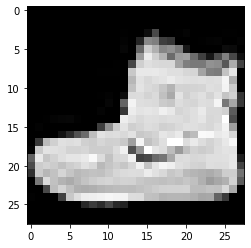

In [10]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap = 'gray')
plt.show()

In [11]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [12]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [13]:
print(class_names[y_train_all[0]])

앵클부츠


In [17]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify = y_train_all, test_size = 0.2, random_state = 42)

In [19]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [20]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [55]:
x_train = x_train / 255
x_val = x_val / 255

In [56]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [57]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [58]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [59]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [60]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [61]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [62]:
fc = MultiClassNetwork(units = 100, batch_size = 256)
fc.fit(x_train, y_train_encoded, x_val = x_val, y_val = y_val_encoded, epochs=40)

........................................

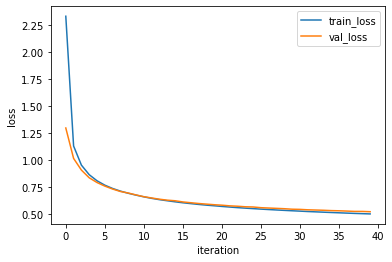

In [63]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [64]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [69]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer = 'sgd', loss = 'mse')
model.fit(x_train, y_train, epochs = 10)

Train on 48000 samples
Epoch 1/10
48000/48000 [==============================] - 3s 68us/sample - loss: nan
Epoch 2/10
48000/48000 [==============================] - 2s 47us/sample - loss: nan
Epoch 3/10
48000/48000 [==============================] - 3s 57us/sample - loss: nan
Epoch 4/10
48000/48000 [==============================] - 4s 83us/sample - loss: nan
Epoch 5/10
48000/48000 [==============================] - 3s 53us/sample - loss: nan
Epoch 6/10
48000/48000 [==============================] - 2s 46us/sample - loss: nan
Epoch 7/10
48000/48000 [==============================] - 2s 47us/sample - loss: nan
Epoch 8/10
48000/48000 [==============================] - 2s 46us/sample - loss: nan
Epoch 9/10
48000/48000 [==============================] - 2s 46us/sample - loss: nan
Epoch 10/10
48000/48000 [==============================] - 2s 46us/sample - loss: nan


In [72]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape = (784, )))
model.add(Dense(10, activation='softmax'))

In [73]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [74]:
history = model.fit(x_train, y_train_encoded, epochs = 40, validation_data = (x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 7s 139us/sample - loss: 1.3954 - accuracy: 0.6499 - val_loss: 0.9669 - val_accuracy: 0.7377
Epoch 2/40
48000/48000 [==============================] - 5s 100us/sample - loss: 0.8399 - accuracy: 0.7491 - val_loss: 0.7455 - val_accuracy: 0.7678
Epoch 3/40
48000/48000 [==============================] - 5s 98us/sample - loss: 0.7045 - accuracy: 0.7691 - val_loss: 0.6599 - val_accuracy: 0.7824
Epoch 4/40
48000/48000 [==============================] - 5s 94us/sample - loss: 0.6399 - accuracy: 0.7841 - val_loss: 0.6071 - val_accuracy: 0.7918
Epoch 5/40
48000/48000 [==============================] - 5s 96us/sample - loss: 0.5991 - accuracy: 0.7952 - val_loss: 0.5729 - val_accuracy: 0.8039
Epoch 6/40
48000/48000 [==============================] - 4s 93us/sample - loss: 0.5701 - accuracy: 0.8041 - val_loss: 0.5483 - val_accuracy: 0.8106
Epoch 7/40
48000/48000 [==============================

In [75]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


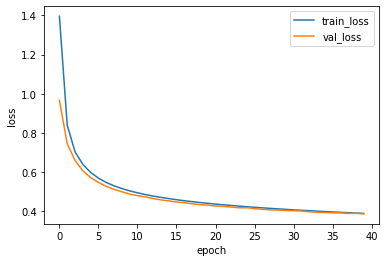

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

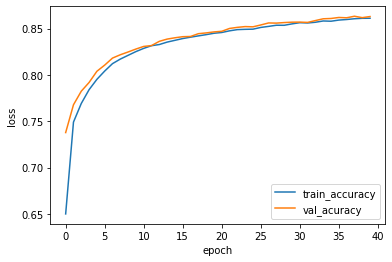

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_acuracy'])
plt.show()

In [78]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose = 0)
print(accuracy)

0.863
